In [1]:
path_to_repo = "./sample_java_repo/csc-java-course-spring-2023-key-value-store-EgorShibaev/"

In [2]:
import os
import javalang

def extract_all_methods_from_repo(path_to_repo):
    """
    Extracts all methods from the file content
    :param path_to_repo: string
    :return: list of strings
    """

    methods_in_repo = {}

    path_to_files = os.path.join(path_to_repo, "src", "main", "java")

    # walk through the files
    for root, _, files in os.walk(path_to_files):
        for file in files:
            if file.endswith(".java"):
                # read the file
                with open(os.path.join(root, file), "r", encoding="utf8") as f:
                    file_content = f.read()

                # extract all methods
                methods = extract_all_methods_from_file(file_content)

                if len(methods) > 0:
                    methods_in_repo[file] = methods

    return methods_in_repo


def extract_code_block(code: str, start_position: int) -> str:
    """
    Extracts the code block starting at the given position according to the opening and closing braces
    :param code: Java or Kotlin code
    :param start_position: position of the opening brace of the code block
    :return: code block and end position of the code block
    """
    open_braces = 0
    code_block_start = start_position
    code_block_end = -1

    for i in range(start_position, len(code)):
        if code[i] == "{":
            open_braces += 1
        elif code[i] == "}":
            open_braces -= 1
            if open_braces == 0:
                code_block_end = i + 1
                break

    if code_block_end == -1:
        return None

    while code[code_block_start] == "\n":
        code_block_start += 1

    return code[code_block_start:code_block_end], code_block_end



def extract_all_methods_from_file(java_source: str) -> str | None:
    """
    This function extracts the code of the method with the
    given name and class from the Java source code
    :param java_source: Java source code
    :param class_name: name of the class
    :param method_name: name of the method
    :return: code of the method
    """
    tree = javalang.parse.parse(java_source)

    methods = []

    for _, node in tree.filter(javalang.tree.MethodDeclaration):
        start_line = node.position.line - 1
        start_position = sum(len(line) + 1 for line in java_source.splitlines()[:start_line]) \
                            + node.position.column - 1
        code_block = extract_code_block(java_source, start_position)
        if code_block is not None:
            methods.append(code_block[0])

    return methods

In [3]:
methods_in_files = extract_all_methods_from_repo(path_to_repo) 

In [4]:
for file, methods in methods_in_files.items():
    print(f"File: {file}")
    print("Nuber of methods: ", len(methods))

File: ByteWrapper.java
Nuber of methods:  5
File: FileBlockLocation.java
Nuber of methods:  2
File: IndexManagerImplementation.java
Nuber of methods:  4
File: KeyValueStoreFactory.java
Nuber of methods:  1
File: KeyValueStoreImplementation.java
Nuber of methods:  8
File: ValueStoreManagerImplementation.java
Nuber of methods:  5


In [5]:
from transformers import AutoTokenizer, AutoModel

tokenizer = AutoTokenizer.from_pretrained("microsoft/CodeGPT-small-java-adaptedGPT2")
model = AutoModel.from_pretrained("microsoft/CodeGPT-small-java-adaptedGPT2")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [6]:
import numpy as np

X = [tokenizer(method, return_tensors='pt') for _, methods in methods_in_files.items() for method in methods]
y = np.array([i for i, (_, methods) in enumerate(methods_in_files.items()) for _ in range(len(methods))])

Heatmap shows pairwise similarity between methods

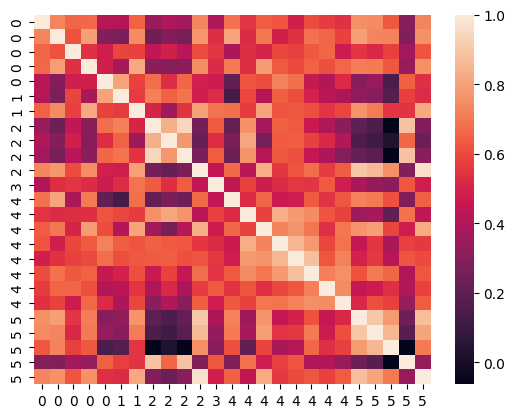

In [7]:
from torch.nn.functional import cosine_similarity

def show_heatmap(X, y, model):
    embeddings = [
        model(**(X[i])).last_hidden_state.mean(dim=1) for i in range(len(X))
    ]

    similarities = [
        [cosine_similarity(emb1, emb2).item() for emb2 in embeddings] for emb1 in embeddings
    ]

    # show the similarity matrix as a heatmap
    import seaborn as sns
    import matplotlib.pyplot as plt

    sns.heatmap(similarities, xticklabels=y, yticklabels=y)
    plt.show()

show_heatmap(X, y, model)

Firstly, I am trying the approach when the loss is calculated concerning each pair of methods. Cosine similarity belongs to segment [-1; +1], so we can use binary cross entropy loss after adding 1 and dividing by 2.

$$Loss = \sum_{i, j} -log \left(\frac{cos\_sim(emb_i, emb_j) + 1}{2}\right)[file_i = file_j] - log \left(1 - \frac{cos\_sim(emb_i, emb_j) + 1}{2}\right)[file_i \neq file_j] $$

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0, loss: 1.2959434986114502
Epoch: 1, loss: 2.428441047668457
Epoch: 2, loss: 1.0212982892990112
Epoch: 3, loss: 1.2869668006896973
Epoch: 4, loss: 1.0333129167556763
Epoch: 5, loss: 0.7589187622070312
Epoch: 6, loss: 0.6807964444160461
Epoch: 7, loss: 0.6915690302848816
Epoch: 8, loss: 0.6822507977485657
Epoch: 9, loss: 0.6428580284118652
Epoch: 10, loss: 0.6005434393882751
Epoch: 11, loss: 0.5743096470832825
Epoch: 12, loss: 0.5654750466346741
Epoch: 13, loss: 0.5650796294212341
Epoch: 14, loss: 0.5630802512168884
Epoch: 15, loss: 0.5541438460350037
Epoch: 16, loss: 0.5389882922172546
Epoch: 17, loss: 0.5218487977981567
Epoch: 18, loss: 0.507061243057251
Epoch: 19, loss: 0.4969523549079895


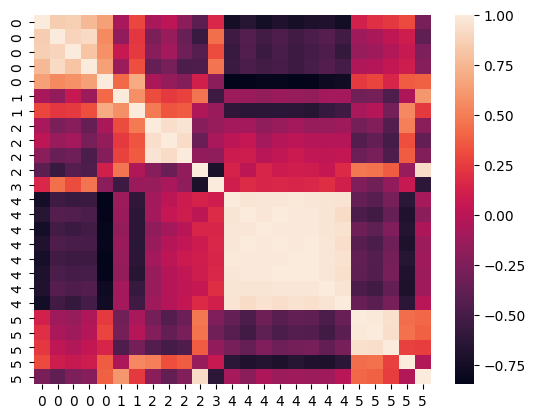

In [8]:
import torch
from torch.nn.functional import cosine_similarity
from torch.nn.functional import binary_cross_entropy
from tqdm.notebook import tqdm

opt = torch.optim.Adam(model.parameters(), lr=1e-4)
epochs = 20

for epoch in tqdm(range(epochs)):

    embeddings = [
        model(**(X[i])).last_hidden_state.mean(dim=1) for i in range(len(X))
    ]

    loss = 0

    for i in range(len(embeddings)):
        for j in range(i + 1, len(embeddings)):
            similarity = (cosine_similarity(embeddings[i], embeddings[j]) + 1) / 2 # normalize to [0, 1]
            # since similarity is in [0, 1], we can use binary cross entropy
            loss += binary_cross_entropy(similarity, torch.tensor([float(y[i] == y[j])]))

    loss /= len(embeddings) * (len(embeddings) - 1) / 2  # mean value

    opt.zero_grad()
    loss.backward()
    opt.step()

    print(f"Epoch: {epoch}, loss: {loss.item()}")

show_heatmap(X, y, model)

The first approach has a problem: files with a bigger number of methods dominate files with a smaller number of methods (we can see how the biggest 4-th file dominated others). To avoid this problem, I divide each term by the number of methods inside/outside the file.

In [12]:
from transformers import AutoTokenizer, AutoModel

tokenizer = AutoTokenizer.from_pretrained("microsoft/CodeGPT-small-java-adaptedGPT2")
model = AutoModel.from_pretrained("microsoft/CodeGPT-small-java-adaptedGPT2")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0, loss: 22.087844848632812
Epoch: 1, loss: 36.96586990356445
Epoch: 2, loss: 18.55946922302246
Epoch: 3, loss: 21.530128479003906
Epoch: 4, loss: 16.39607810974121
Epoch: 5, loss: 12.686688423156738
Epoch: 6, loss: 11.691187858581543
Epoch: 7, loss: 10.806463241577148
Epoch: 8, loss: 9.766985893249512
Epoch: 9, loss: 8.983475685119629
Epoch: 10, loss: 8.49062728881836
Epoch: 11, loss: 8.12218189239502
Epoch: 12, loss: 7.763298511505127
Epoch: 13, loss: 7.407846450805664
Epoch: 14, loss: 7.142560958862305
Epoch: 15, loss: 7.013399124145508
Epoch: 16, loss: 6.9541425704956055
Epoch: 17, loss: 6.873478889465332
Epoch: 18, loss: 6.749717712402344
Epoch: 19, loss: 6.622056484222412


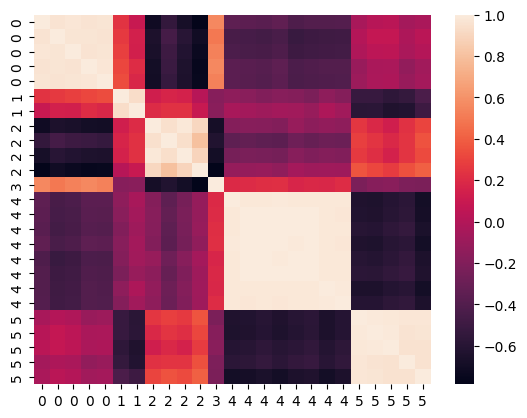

In [13]:
opt = torch.optim.Adam(model.parameters(), lr=1e-4)
epochs = 20
count_same = [(y == i).sum() for i in y]

for epoch in tqdm(range(epochs)):

    embeddings = [
        model(**(X[i])).last_hidden_state.mean(dim=1) for i in range(len(X))
    ]

    loss = 0

    for i in range(len(embeddings)):
        for j in range(i + 1, len(embeddings)):
            similarity = (cosine_similarity(embeddings[i], embeddings[j]) + 1) / 2 # normalize to [0, 1]
            # since similarity is in [0, 1], we can use binary cross entropy
            if y[i] == y[j]:
                loss += binary_cross_entropy(similarity, torch.ones(1)) / count_same[y[i]]
            else:
                loss += binary_cross_entropy(similarity, torch.zeros(1)) / (len(X) - count_same[y[i]])

    opt.zero_grad()
    loss.backward()
    opt.step()

    print(f"Epoch: {epoch}, loss: {loss.item()}")

show_heatmap(X, y, model)

The result is much better now - methods in the smaller files are closer now than in the previous case.

In [16]:
!jupyter nbconvert --to html task2.ipynb

[NbConvertApp] Converting notebook task2.ipynb to html
[NbConvertApp] Writing 741097 bytes to task2.html
